In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play, Schedule
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [125]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_jakarta'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-12-01 12:20:47,472: Credentials are already in use. The existing account in the session will be replaced.


In [126]:
qubit = 0
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)

In [127]:
print(freq01_estimate)

5236361516.419317


In [128]:
print(frequencies)

[5.22136152e+09 5.22196152e+09 5.22256152e+09 5.22316152e+09
 5.22376152e+09 5.22436152e+09 5.22496152e+09 5.22556152e+09
 5.22616152e+09 5.22676152e+09 5.22736152e+09 5.22796152e+09
 5.22856152e+09 5.22916152e+09 5.22976152e+09 5.23036152e+09
 5.23096152e+09 5.23156152e+09 5.23216152e+09 5.23276152e+09
 5.23336152e+09 5.23396152e+09 5.23456152e+09 5.23516152e+09
 5.23576152e+09 5.23636152e+09 5.23696152e+09 5.23756152e+09
 5.23816152e+09 5.23876152e+09 5.23936152e+09 5.23996152e+09
 5.24056152e+09 5.24116152e+09 5.24176152e+09 5.24236152e+09
 5.24296152e+09 5.24356152e+09 5.24416152e+09 5.24476152e+09
 5.24536152e+09 5.24596152e+09 5.24656152e+09 5.24716152e+09
 5.24776152e+09 5.24836152e+09 5.24896152e+09 5.24956152e+09
 5.25016152e+09 5.25076152e+09 5.25136152e+09]


In [129]:
def spectroscopy_scheds(qubit, pulse_params, backend):
    freq_param = circuit.Parameter("frequency")
    with pulse.build(backend=backend, name="spectroscopy") as schedule:
        pulse.shift_frequency(freq_param, DriveChannel(qubit))
        pulse.play(
            GaussianSquare(duration=pulse_params["duration"], 
                           amp=pulse_params["amp"], 
                           sigma=pulse_params["sigma"], 
                           width=pulse_params["width"]), DriveChannel(qubit))
        pulse.shift_frequency(-freq_param, DriveChannel(qubit))
        
    return schedule, freq_param

def amplitude_scheds(qubit, pulse_params, backend):
    amp_param = circuit.Parameter("amp")
    with pulse.build(backend=backend, name="amp_sweep") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=amp_param, 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule, amp_param

def x_gate_scheds(qubit, pulse_params, backend):
    with pulse.build(backend=backend, name="x_gate") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=pulse_params["amplitude"], 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule

def template_circuit(param, gate_name):
    temp_circ = QuantumCircuit(1)
    if param is not None:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[param]), (0,))
        temp_circ.measure_active()
    else:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[]), (0,))
    return temp_circ

def spectroscopy_circuits(qubit, frequencies, pulse_params, backend):
    gname = "Spec"
    sched, freq_param = spectroscopy_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(freq_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[freq_param])
    
    center_freq = backend.defaults().qubit_freq_est[qubit]
    
    circs = []
    for freq in frequencies:
        freq_shift = freq
        freq_shift -= center_freq
        freq_shift = np.round(freq_shift, decimals=3)
        assigned_circ = circuit.assign_parameters({freq_param: freq_shift}, inplace=False)
        circs.append(assigned_circ)
    return circs

def amplitude_circuits(qubit, amplitudes, pulse_params, backend):
    gname = "Amp"
    sched, amp_param = amplitude_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(amp_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[amp_param])
    
    circs = []
    for amp in amplitudes:
        assigned_circ = circuit.assign_parameters({amp_param: amp}, inplace=False)
        circs.append(assigned_circ)
    return circs

def x_gate_circuits(qubit, pulse_params, backend):
    gname = "Custom_x"

    sched = x_gate_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(None, gname)
    circuit.add_calibration(gname, (qubit,), sched)
#     circs.append(circuit)
    
    return circuit

## Spectroscopy pulse parameters - using a GaussianSquare pulse to perform qubit spectroscopy

In [215]:
pulse_params = {}
pulse_params["duration"] = 1024
pulse_params["amp"] = 0.1
pulse_params["sigma"] = 256
pulse_params["width"] = 0


In [216]:
circs = spectroscopy_circuits(qubit, frequencies, pulse_params, backend)

In [217]:
transpiled_circs = transpile(circs, backend, initial_layout=[0])

In [218]:
# transpiled_circs[0].draw()

In [220]:
example_sched = draw(schedule(transpiled_circs[29], backend), backend=backend)
# example_sched.draw()
example_sched.savefig("example_spectroscopy_schedule.png")

In [133]:
job = backend.run(transpiled_circs, job_name="spectroscopy", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7aefca62b8234d7b51ae0


In [134]:
# 11/21/spectroscopy
# jakarta (11:51) 619a768168476d6e298a8394

# lagos (2:16) 619a9b38cd37f33609f2702d
# armonk (3:29) 619aac3a53ac6ccf4ad59760

#11/23/2021 
# lagos (12:03) 619c75f28982d995183399dc

# jakarta (12:36) 619c7dc18982d9836e339a69

# 11/30/2021 
# lagos (1:29) - 61a66d70a62b826eb1b5136b


#12/1/2021
# jakarta - 61a7aefca62b8234d7b51ae0

# backend = provider.get_backend("ibmq_jakarta")
results = backend.retrieve_job("61a7aefca62b8234d7b51ae0").result()

In [135]:
print(results.get_counts())

[{'0': 2016, '1': 32}, {'0': 2021, '1': 27}, {'0': 2024, '1': 24}, {'0': 2030, '1': 18}, {'0': 2026, '1': 22}, {'0': 2021, '1': 27}, {'0': 2007, '1': 41}, {'0': 1978, '1': 70}, {'0': 1921, '1': 127}, {'0': 1872, '1': 176}, {'0': 1869, '1': 179}, {'0': 1812, '1': 236}, {'0': 1842, '1': 206}, {'0': 1875, '1': 173}, {'0': 1919, '1': 129}, {'0': 1959, '1': 89}, {'0': 2012, '1': 36}, {'0': 2018, '1': 30}, {'0': 2015, '1': 33}, {'0': 1966, '1': 82}, {'0': 1876, '1': 172}, {'0': 1828, '1': 220}, {'0': 1732, '1': 316}, {'0': 1660, '1': 388}, {'0': 1630, '1': 418}, {'0': 1601, '1': 447}, {'0': 1629, '1': 419}, {'0': 1664, '1': 384}, {'0': 1741, '1': 307}, {'0': 1820, '1': 228}, {'0': 1871, '1': 177}, {'0': 1941, '1': 107}, {'0': 1995, '1': 53}, {'0': 2027, '1': 21}, {'0': 2019, '1': 29}, {'0': 2007, '1': 41}, {'0': 1960, '1': 88}, {'0': 1929, '1': 119}, {'0': 1893, '1': 155}, {'0': 1841, '1': 207}, {'0': 1875, '1': 173}, {'0': 1872, '1': 176}, {'0': 1899, '1': 149}, {'0': 1947, '1': 101}, {'0':

In [136]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.015625, 0.01318359375, 0.01171875, 0.0087890625, 0.0107421875, 0.01318359375, 0.02001953125, 0.0341796875, 0.06201171875, 0.0859375, 0.08740234375, 0.115234375, 0.1005859375, 0.08447265625, 0.06298828125, 0.04345703125, 0.017578125, 0.0146484375, 0.01611328125, 0.0400390625, 0.083984375, 0.107421875, 0.154296875, 0.189453125, 0.2041015625, 0.21826171875, 0.20458984375, 0.1875, 0.14990234375, 0.111328125, 0.08642578125, 0.05224609375, 0.02587890625, 0.01025390625, 0.01416015625, 0.02001953125, 0.04296875, 0.05810546875, 0.07568359375, 0.10107421875, 0.08447265625, 0.0859375, 0.07275390625, 0.04931640625, 0.02978515625, 0.02099609375, 0.0146484375, 0.01416015625, 0.0126953125, 0.01513671875, 0.0146484375]


In [137]:
frequencies_GHz = frequencies*1e-9
print(frequencies_GHz)

[5.22136152 5.22196152 5.22256152 5.22316152 5.22376152 5.22436152
 5.22496152 5.22556152 5.22616152 5.22676152 5.22736152 5.22796152
 5.22856152 5.22916152 5.22976152 5.23036152 5.23096152 5.23156152
 5.23216152 5.23276152 5.23336152 5.23396152 5.23456152 5.23516152
 5.23576152 5.23636152 5.23696152 5.23756152 5.23816152 5.23876152
 5.23936152 5.23996152 5.24056152 5.24116152 5.24176152 5.24236152
 5.24296152 5.24356152 5.24416152 5.24476152 5.24536152 5.24596152
 5.24656152 5.24716152 5.24776152 5.24836152 5.24896152 5.24956152
 5.25016152 5.25076152 5.25136152]


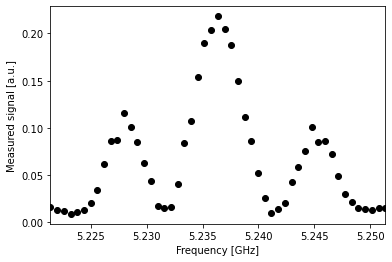

In [138]:
plt.scatter(frequencies_GHz, np.real(exp_vals), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 51
    # variables        = 3
    chi-square         = 0.06816996
    reduced chi-square = 0.00142021
    Akaike info crit   = -331.496423
    Bayesian info crit = -325.700946
[[Variables]]
    amplitude:  0.00192177 +/- 1.8046e-04 (9.39%) (init = 0.004006165)
    center:     5.23634724 +/- 2.7587e-04 (0.01%) (init = 5.235312)
    sigma:      0.00297091 +/- 3.9502e-04 (13.30%) (init = 0.0051)
    fwhm:       0.00594182 +/- 7.9004e-04 (13.30%) == '2.0000000*sigma'
    height:     0.20590230 +/- 0.01916567 (9.31%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.714


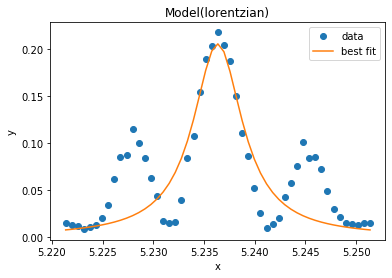

In [139]:
import lmfit

model = lmfit.models.LorentzianModel()
params = model.guess(np.array(exp_vals), x=np.array(frequencies_GHz))

result = model.fit(np.array(exp_vals), params, x=frequencies_GHz)
result.plot_fit()
print(result.fit_report())

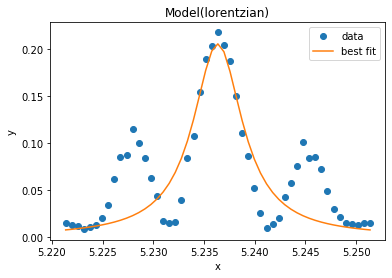

In [141]:
fig = result.plot_fit()
fig.get_figure().savefig("ibmq_jakarta_frequency_sweep_bestfit_12_1.png")

In [142]:
qubit_frequency = result.params["center"].value
print(F"Our freq: {qubit_frequency} and reported: {freq01_estimate*1e-9}")

Our freq: 5.236347240597054 and reported: 5.236361516419318


In [152]:
x_sched = inst_map.get("x", qubit)
print(x_sched.instructions[0][1].pulse.amp)

(0.19853704532034197+0j)


In [144]:
drag_params = {}
drag_params["duration"] = x_sched.instructions[0][1].pulse.duration
drag_params["sigma"] = x_sched.instructions[0][1].pulse.sigma
drag_params["beta"] = x_sched.instructions[0][1].pulse.beta
drag_params["frequency"] = qubit_frequency*1.0e9

print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.9740804109491876, 'frequency': 5236347240.597054}


In [222]:
drag_sched = draw(x_sched, backend=backend)
drag_sched.savefig("drag_pulse_example", bbox_inches='tight')

In [209]:
amplitudes = np.linspace(-0.95, 0.95, 51)

In [210]:
amp_circs = amplitude_circuits(qubit, amplitudes, drag_params, backend)

In [211]:
transpiled_circs = transpile(amp_circs, backend, initial_layout=[0])

In [212]:
transpiled_circs[0].draw()

┌─────────────────────────┐ ░ ┌─┐
      q_0 -> 0 ┤ Amp(-0.950000000000000) ├─░─┤M├
               └─────────────────────────┘ ░ └╥┘
ancilla_0 -> 1 ───────────────────────────────╫─
                                              ║ 
ancilla_1 -> 2 ───────────────────────────────╫─
                                              ║ 
ancilla_2 -> 3 ───────────────────────────────╫─
                                              ║ 
ancilla_3 -> 4 ───────────────────────────────╫─
                                              ║ 
ancilla_4 -> 5 ───────────────────────────────╫─
                                              ║ 
ancilla_5 -> 6 ───────────────────────────────╫─
                                              ║ 
    measure: 1/═══════════════════════════════╩═
                                              0

In [213]:
amp_sched = draw(schedule(transpiled_circs[50], backend), backend=backend)
amp_sched.savefig("jakarta_example_amp_sched")

In [151]:
job = backend.run(transpiled_circs, job_name="amplitude", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7b4b2a62b825368b51b0a


In [153]:
# 11/23/2021
# lagos (12:34) 619c7a2768476d433a8a9304

# jakarta (12:45) 619c800853ac6c5c52d5a4c6

# 11/30/2021 
# lagos 61a67ba3a62b8250ceb513a5

#12/1/2021
# jakarta 61a7b4b2a62b825368b51b0a
# backend = provider.get_backend("ibmq_jakarta")
results = backend.retrieve_job("61a7b4b2a62b825368b51b0a").result()

In [154]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.72265625, 0.4638671875, 0.20849609375, 0.0498046875, 0.02001953125, 0.13720703125, 0.35693359375, 0.61181640625, 0.8525390625, 0.95947265625, 0.9169921875, 0.74951171875, 0.4716796875, 0.1865234375, 0.037109375, 0.0224609375, 0.16943359375, 0.421875, 0.71435546875, 0.9140625, 0.970703125, 0.8544921875, 0.6240234375, 0.3291015625, 0.11474609375, 0.01171875, 0.07763671875, 0.306640625, 0.59033203125, 0.8388671875, 0.95703125, 0.93701171875, 0.7373046875, 0.4755859375, 0.197265625, 0.03173828125, 0.02294921875, 0.16845703125, 0.42431640625, 0.7021484375, 0.89599609375, 0.96826171875, 0.8828125, 0.67138671875, 0.3984375, 0.16748046875, 0.02294921875, 0.03466796875, 0.1796875, 0.41796875, 0.66552734375]


In [155]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

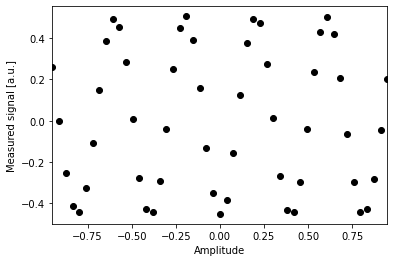

In [156]:
# baseline_remove(np.real(exp_vals))
plt.scatter(amplitudes, baseline_remove(np.real(exp_vals)), color='black') # plot real part of sweep values
plt.xlim([min(amplitudes), max(amplitudes)])
plt.xlabel("Amplitude")
plt.ylabel("Measured signal [a.u.]")
plt.show()

# The following data fitting code was copied from the Qiskit tutorial on Calibrating Qubits with Qiskit Pulse
https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html#calib

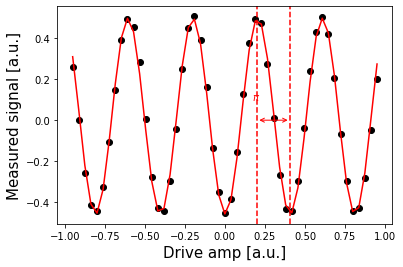

In [161]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


fit_params, y_fit = fit_function(amplitudes,
                                 baseline_remove(np.real(exp_vals)), 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [0.8, 0.8, 0.5, 2])

plt.scatter(amplitudes, baseline_remove(np.real(exp_vals)), color='black')
plt.plot(amplitudes, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.savefig("ibmq_jakarta_amplitude_sweep_bestfit_12_1.png")
plt.show()

In [162]:
print(fit_params)

[0.47747258 0.01998254 0.40486655 3.18698784]


In [163]:
pi_amp = abs(drive_period / 2)
print(f"Our Pi amplitude = {pi_amp+0j} and reported: {x_sched.instructions[0][1].pulse.amp}")

Our Pi amplitude = (0.20243327589580798+0j) and reported: (0.19853704532034197+0j)


In [124]:
# job = backend.retrieve_job("619c800853ac6c5c52d5a4c6")
# props = job.properties()
# for gate in props.gates:
#     if gate.name == "x0":
#         print(gate.parameters)

In [164]:
drag_params["amplitude"] = pi_amp+0j
print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.9740804109491876, 'frequency': 5236347240.597054, 'amplitude': (0.20243327589580798+0j)}


In [165]:
from qiskit.circuit.library import CXGate
from qiskit.circuit import Qubit, QuantumRegister
x_circs = x_gate_circuits(qubit, drag_params, backend)
qreg = QuantumRegister(1)
x_circs.add_register(qreg)

x_circs.append(CXGate(), [0,1])
x_circs.measure_active()
x_circs.draw()



┌──────────┐      ░ ┌─┐   
      q_0: ┤ Custom_x ├──■───░─┤M├───
           └──────────┘┌─┴─┐ ░ └╥┘┌─┐
  q1236_0: ────────────┤ X ├─░──╫─┤M├
                       └───┘ ░  ║ └╥┘
measure: 2/═════════════════════╩══╩═
                                0  1

In [166]:
transpiled_test = transpile(x_circs, backend)
transpiled_test.draw()

┌──────────┐      ░ ┌─┐   
      q_0 -> 0 ┤ Custom_x ├──■───░─┤M├───
               └──────────┘┌─┴─┐ ░ └╥┘┌─┐
  q1236_0 -> 1 ────────────┤ X ├─░──╫─┤M├
                           └───┘ ░  ║ └╥┘
ancilla_0 -> 2 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_1 -> 3 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_2 -> 4 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_3 -> 5 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_4 -> 6 ─────────────────────╫──╫─
                                    ║  ║ 
    measure: 2/═════════════════════╩══╩═
                                    0  1

In [167]:
job = backend.run(x_circs, job_name="simple_cnot", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a7b68d313f812074c3bc9b


In [176]:
from qiskit.visualization import plot_histogram

#simple cnot experiment
# jakarta (1:33) 619c8acd53ac6c6f7dd5a511

# simple cnot 11/30/2021
# lagos 61a6c6aed28a88365c8cfeaf

# simple cnot 12/1/2021
# jakarta 61a7b68d313f812074c3bc9b 
results = backend.retrieve_job("61a7b68d313f812074c3bc9b").result()
# counts = results.get_counts()
# plot_histogram(counts)

In [177]:
print(results.get_counts())

{'00': 16, '01': 60, '10': 66, '11': 1906}


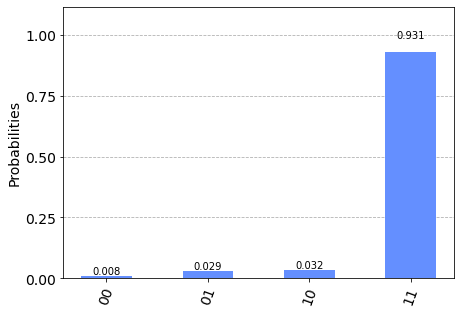

In [180]:
fig = plot_histogram(results.get_counts())
fig

In [181]:
fig.savefig("jakarta_12_1_customx_simple_cnot_experiment_results.png")

In [182]:
import qiskit.ignis.verification.tomography
from qiskit import QuantumRegister
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

In [183]:
xc = x_gate_circuits(qubit, drag_params, backend)

custom_x_qpt_circs = process_tomography_circuits(xc, [0])

In [184]:
custom_x_qpt_circs[0].draw()

░ ┌──────────┐ ░ ┌───┐┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤ H ├┤M├
       ░ └──────────┘ ░ └───┘└╥┘
c1: 1/════════════════════════╩═
                              0

In [53]:
custom_x_qpt_circs[1].draw()

░ ┌──────────┐ ░ ┌─────┐┌───┐┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤ Sdg ├┤ H ├┤M├
       ░ └──────────┘ ░ └─────┘└───┘└╥┘
c0: 1/═══════════════════════════════╩═
                                     0

In [54]:
custom_x_qpt_circs[2].draw()

░ ┌──────────┐ ░ ┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤M├
       ░ └──────────┘ ░ └╥┘
c0: 1/═══════════════════╩═
                         0

In [185]:
job = qiskit.execute(custom_x_qpt_circs, backend, shots=4000)
print(job.job_id())

61a7b8d7d28a8870f68d049a


In [189]:
# IBM lagos
# 61a70910313f811ba6c3b887

# ibm jakarta 12/1 
# 61a7b8d7d28a8870f68d049a
qpt_job = backend.retrieve_job("61a7b8d7d28a8870f68d049a")
qpt_tomo = ProcessTomographyFitter(qpt_job.result(), custom_x_qpt_circs)
qpt_tomo.data

{(('Zp',), ('X',)): {'0': 2004, '1': 1996},
 (('Zp',), ('Y',)): {'0': 2016, '1': 1984},
 (('Zp',), ('Z',)): {'0': 140, '1': 3860},
 (('Zm',), ('X',)): {'0': 1989, '1': 2011},
 (('Zm',), ('Y',)): {'0': 1943, '1': 2057},
 (('Zm',), ('Z',)): {'0': 3946, '1': 54},
 (('Xp',), ('X',)): {'0': 3946, '1': 54},
 (('Xp',), ('Y',)): {'0': 2103, '1': 1897},
 (('Xp',), ('Z',)): {'0': 2091, '1': 1909},
 (('Yp',), ('X',)): {'0': 2142, '1': 1858},
 (('Yp',), ('Y',)): {'0': 156, '1': 3844},
 (('Yp',), ('Z',)): {'0': 1860, '1': 2140}}

In [190]:
import time
# Tomographic reconstruction
t = time.time()
choi_fit_lstsq = qpt_tomo.fit(method='lstsq')

default_xc = QuantumCircuit(1)
default_xc.x(0)
target_unitary = qi.Operator(default_xc)

print('Fit time:', time.time() - t)
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)))

Fit time: 0.006003379821777344
Average gate fidelity: F = 0.96949


In [191]:
print(target_unitary)

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))


In [204]:
from qiskit.quantum_info.operators import Operator, Pauli
ZX = Pauli(label="ZX")

In [205]:
op = Operator(ZX)

In [206]:
print(op)

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [207]:
default_cx = QuantumCircuit(2)
default_cx.cx(0,1)
target_unitary = qi.Operator(default_cx)
print(target_unitary)

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
